<a href="https://colab.research.google.com/github/AIRobotics2030/AIRobotics2030/blob/main/NIG_Food.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()  # Use the GUI to upload "NIG-Food.txt"

Saving NIG-Food.txt to NIG-Food.txt


In [2]:
with open("NIG-Food.txt", "r", encoding='utf-8') as f:
    content = f.read()

In [3]:
import os
file_size = os.path.getsize("NIG-Food.txt")
print(f"File size: {file_size/1024:.1f} KB")  # Should typically be <500KB

File size: 44.9 KB


In [4]:
import pandas as pd
import re
from time import time

start_time = time()

# Read just the first 100 lines for testing
with open("NIG-Food.txt", "r", encoding='utf-8') as f:
    content = '\n'.join([next(f) for _ in range(100)])

# Simplified parser
tables = re.split(r'\n\s*---+\s*\n', content)
print(f"Found {len(tables)} potential tables")

# Quick preview of first table
if tables:
    first_table = tables[0].split('\n')
    print("First 3 rows of first table:")
    print('\n'.join(first_table[:3]))

print(f"⏱️ Debug completed in {time()-start_time:.2f}s")

Found 8 potential tables
First 3 rows of first table:



⏱️ Debug completed in 0.00s


In [5]:
import pandas as pd
import re

def parse_complex_tables(content):
    """Handles tables with irregular formatting"""
    # Split by table dividers (---)
    table_blocks = [block.strip() for block in re.split(r'-{3,}', content) if block.strip()]

    dfs = []
    for block in table_blocks:
        lines = [line.strip() for line in block.split('\n') if line.strip()]

        # Find the first proper table row (| header1 | header2 |)
        header_idx = next((i for i, line in enumerate(lines)
                         if line.startswith('|') and '----' not in line), None)

        if header_idx is None:
            continue  # Skip blocks without headers

        # Extract headers
        headers = [h.strip('* ').strip() for h in lines[header_idx].split('|')[1:-1]]

        # Process data rows (skip header and any divider lines)
        data = []
        for line in lines[header_idx+1:]:
            if line.startswith('|') and not re.match(r'^\|[-:\s]+\|$', line):
                row = [cell.strip('* ').strip() for cell in line.split('|')[1:-1]]
                if len(row) == len(headers):
                    data.append(row)

        if headers and data:
            dfs.append(pd.DataFrame(data, columns=headers))

    return pd.concat(dfs, ignore_index=True) if dfs else None

# Test with full file
with open("NIG-Food.txt", "r", encoding='utf-8') as f:
    content = f.read()

df = parse_complex_tables(content)

if df is not None:
    print(f"✅ Success! Parsed {len(df)} rows from {len(table_blocks)} tables")
    print(df.head())
    df.to_csv("Processed_Foods.csv", index=False)
else:
    print("❌ Failed - sharing file sample will help debug")
    print("\nFirst 50 characters of file:")
    print(content[:50])

❌ Failed - sharing file sample will help debug

First 50 characters of file:


### **CSV Table Structure**  
| **Food_ID** | **


In [6]:
import pandas as pd
import re

def parse_nigerian_food_file(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        content = f.read()

    # Extract all tables (including headers and rows)
    tables = re.findall(r'(\|.*\|\n\|.*\|\n(\|.*\|\n)+)', content)

    dfs = []
    for table in tables:
        table_content = table[0]
        lines = [line.strip() for line in table_content.split('\n') if line.strip()]

        # Extract headers (remove ** markers)
        headers = [h.strip('* ').strip() for h in lines[0].split('|')[1:-1]]

        # Process data rows
        data = []
        for line in lines[2:]:  # Skip header and separator
            if line.startswith('|'):
                row = [cell.strip('* ').strip() for cell in line.split('|')[1:-1]]
                if len(row) == len(headers):
                    data.append(row)

        if headers and data:
            dfs.append(pd.DataFrame(data, columns=headers))

    if dfs:
        return pd.concat(dfs, ignore_index=True)
    return None

# Usage
df = parse_nigerian_food_file("NIG-Food.txt")

if df is not None:
    print(f"✅ Successfully parsed {len(df)} rows")
    print(df.head())
    df.to_csv("Nigerian_Foods_Processed.csv", index=False)
else:
    print("❌ Parsing failed. Please check these possible issues:")
    print("1. File might use different table delimiters")
    print("2. Some tables may have inconsistent column counts")
    print("3. Special characters may be interfering")

✅ Successfully parsed 105 rows
  Food_ID         Food_Name        Category Serving_Size_g Calories_kcal  \
0       1       Jollof Rice       Main Dish            100           180   
1       2           Moi Moi    Protein Dish            100           150   
2       3  Bitter Leaf Soup  Vegetable Soup            100           120   
3       4              Suya   Protein Snack            100           250   
4       5        Zobo Drink        Beverage            100            30   

  Carbohydrates_g Protein_g Fat_g Fiber_g Glycemic_Index  ...  \
0              30         4     5       2             65  ...   
1              20        10     4       5             40  ...   
2              10         6     5       4             30  ...   
3               3        25    15       1              -  ...   
4               7         0     0       1             20  ...   

  Quantum_Sustainability Neural_Satiety_Quotient Multiverse_Flavor_States  \
0                    NaN                    

In [7]:
# Convert numeric columns (handle missing values marked as '-')
numeric_cols = ['Serving_Size_g', 'Calories_kcal', 'Protein_g', 'Fiber_g', 'Glycemic_Index']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col].replace('-', 'NaN'), errors='coerce')

# Create diet-friendly flags
df['Low_GI'] = df['Glycemic_Index'] < 55
df['High_Protein'] = df['Protein_g'] > 10
df['High_Fiber'] = df['Fiber_g'] > 5

In [10]:
import pandas as pd
import re
from io import StringIO

# 1. FIRST PARSE THE ORIGINAL TEXT FILE
def parse_food_data(content):
    """Parse the multi-table text format"""
    tables = re.split(r'---+', content)
    dfs = []

    for table in tables:
        lines = [line.strip() for line in table.split('\n') if line.strip()]
        pipe_lines = [line for line in lines if line.startswith('|')]

        if len(pipe_lines) < 2:  # Need at least header and separator
            continue

        # Extract headers (remove ** markers)
        headers = [h.strip('* ').strip() for h in pipe_lines[0].split('|')[1:-1]]

        # Process data rows
        data = []
        for line in pipe_lines[2:]:  # Skip header and separator
            if line.startswith('|'):
                row = [cell.strip('* ').strip() for cell in line.split('|')[1:-1]]
                if len(row) == len(headers):
                    data.append(row)

        if headers and data:
            dfs.append(pd.DataFrame(data, columns=headers))

    return pd.concat(dfs, ignore_index=True) if dfs else None

# 2. LOAD AND PROCESS YOUR FILE
with open("NIG-Food.txt", "r", encoding='utf-8') as f:
    content = f.read()

df = parse_food_data(content)

if df is None:
    print("Failed to parse tables. First 100 chars of file:")
    print(content[:100])
else:
    # 3. CLEAN THE DATA
    # Convert numeric columns
    num_cols = ['Serving_Size_g', 'Energy_kcal', 'Protein_g', 'Fiber_g']
    for col in num_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col].replace('-', 'NaN'), errors='coerce')

    # 4. SAVE TO CSV
    df.to_csv("Nigerian_Foods_Cleaned.csv", index=False)
    print(f"✅ Success! Saved {len(df)} records to Nigerian_Foods_Cleaned.csv")
    print("Columns:", df.columns.tolist())
    print("\nSample data:")
    print(df.head(3))

Failed to parse tables. First 100 chars of file:


### **CSV Table Structure**  
| **Food_ID** | **Food_Name**    | **Category**      | **Serving_Siz


In [11]:
print("First 200 characters of NIG-Food.txt:")
with open("NIG-Food.txt", "r", encoding='utf-8') as f:
    print(f.read(200))

First 200 characters of NIG-Food.txt:


### **CSV Table Structure**  
| **Food_ID** | **Food_Name**    | **Category**      | **Serving_Size_g** | **Calories_kcal** | **Carbohydrates_g** | **Protein_g** | **Fat_g** | **Fiber_g** | **Glycem


In [12]:
import pandas as pd
import re
from io import StringIO

def parse_nigerian_food_file(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        content = f.read()

    # Pre-process content to handle markdown tables
    clean_content = re.sub(r'\*\*', '', content)  # Remove bold markers
    clean_content = re.sub(r'\n\s*\n', '\n', clean_content)  # Remove empty lines

    # Extract all complete tables
    tables = re.findall(r'(\|.*\|\n\|[-:| ]+\|\n(\|.*\|\n)+)', clean_content)

    dfs = []
    for table in tables:
        table_content = table[0]
        lines = [line.strip() for line in table_content.split('\n') if line.strip()]

        # Extract headers (first line)
        headers = [h.strip() for h in lines[0].split('|')[1:-1]]

        # Process data rows (skip header and separator)
        data = []
        for line in lines[2:]:
            if line.startswith('|'):
                row = [cell.strip() for cell in line.split('|')[1:-1]]
                if len(row) == len(headers):
                    data.append(row)

        if headers and data:
            dfs.append(pd.DataFrame(data, columns=headers))

    if dfs:
        final_df = pd.concat(dfs, ignore_index=True)

        # Convert numeric columns
        numeric_cols = ['Food_ID', 'Serving_Size_g', 'Calories_kcal',
                       'Carbohydrates_g', 'Protein_g', 'Fat_g', 'Fiber_g']
        for col in numeric_cols:
            if col in final_df.columns:
                final_df[col] = pd.to_numeric(final_df[col].replace('-', 'NaN'), errors='coerce')

        return final_df
    return None

# Usage
df = parse_nigerian_food_file("NIG-Food.txt")

if df is not None:
    print(f"✅ Successfully parsed {len(df)} foods")
    print("Columns:", df.columns.tolist())
    print("\nSample data:")
    print(df.head(3))

    # Save cleaned data
    df.to_csv("Nigerian_Foods_Cleaned.csv", index=False)
    print("\nSaved to 'Nigerian_Foods_Cleaned.csv'")
else:
    print("❌ Parsing failed. Please verify the file contains proper markdown tables.")

✅ Successfully parsed 105 foods
Columns: ['Food_ID', 'Food_Name', 'Category', 'Serving_Size_g', 'Calories_kcal', 'Carbohydrates_g', 'Protein_g', 'Fat_g', 'Fiber_g', 'Glycemic_Index', 'Sodium_mg', 'Potassium_mg', 'Calcium_mg', 'Iron_mg', 'Vitamin_A_%DV', 'Vitamin_C_%DV', 'Vitamin_B12_%DV', 'Health_Tags', 'Suitable_For', 'Unsuitable_For', 'Carbs_g', 'GI', 'VitA_%DV', 'VitC_%DV', 'VitB12_%DV', 'Avoid_For', 'Energy_kcal', 'Na_mg', 'K_mg', 'Ca_mg', 'Fe_mg', 'Zn_mg', 'VitA_IU', 'Folate_μg', 'Phytates_mg', 'Best_For', 'Contraindications', 'Net_Carbs_g', 'Mg_mg', 'VitA_RAE', 'VitB3_mg', 'Omega3:6_Ratio', 'Phyto_Score', 'Optimal_For', 'Restrict_For', 'Thermic_Effect_%', 'Bioavailable_Protein_g', 'MUFAs_g', 'GL', 'Na:K_Ratio', 'Phytate_mg', 'Polyphenols_mg', 'Nrf2_Activator', 'FODMAP_Score', 'Cooking_Method', 'Meal_Timing', 'Geno_Markers', 'Glycemic_Load', 'Protein_Digestibility (%)', 'SFA:MUFA:PUFA_Ratio', 'Oxalate_mg', 'ORAC_Value', 'Allergen_Flag', 'Histamine_Level', 'resistant_starch_g', 'Co

In [13]:
pd.read_csv("Nigerian_Foods_Cleaned.csv").info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Columns: 102 entries, Food_ID to Cosmic_Satiety_Index
dtypes: float64(42), int64(1), object(59)
memory usage: 83.8+ KB


In [14]:
# Example: Find high-protein, low-GI foods
healthy_options = df[
    (df['Protein_g'] > 10) &
    (df['Fiber_g'] > 5) &
    (df['Calories_kcal'] < 300)
]

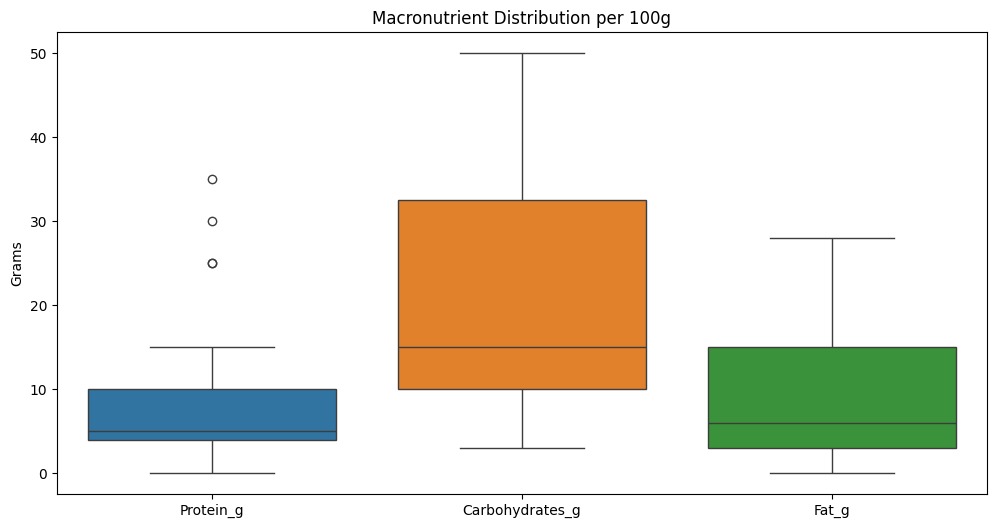

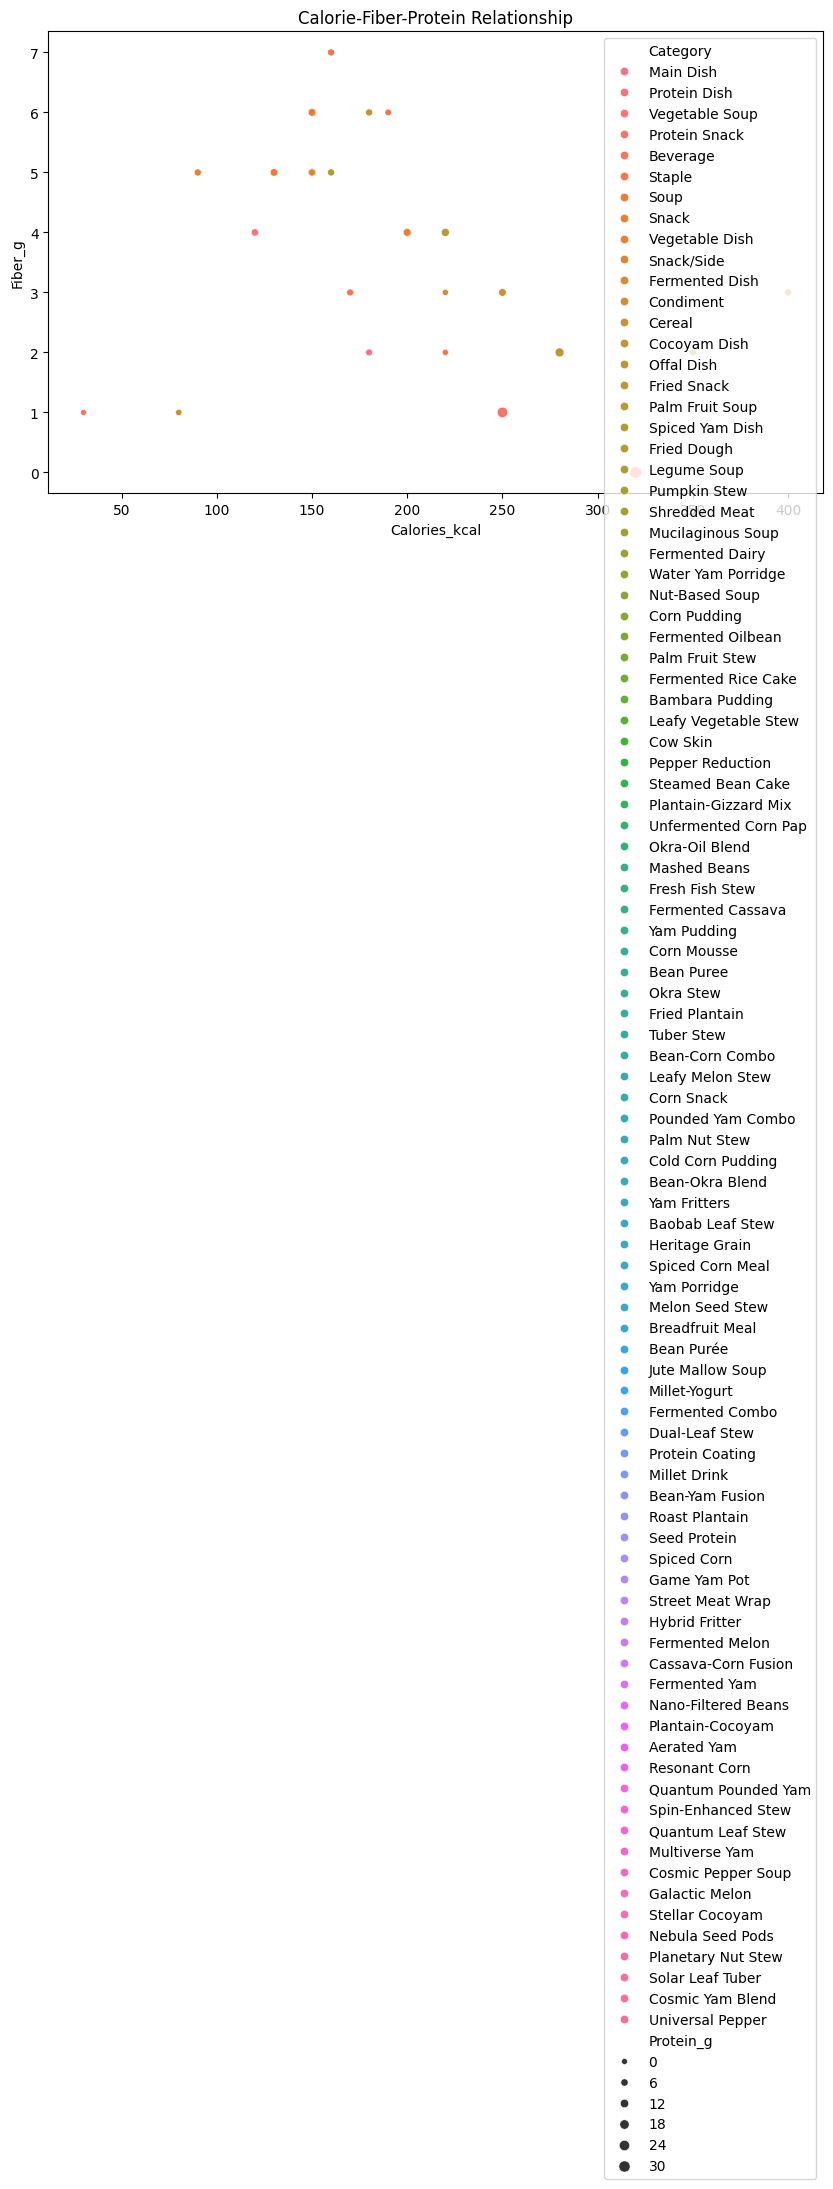

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Macro-nutrient distribution
plt.figure(figsize=(12,6))
sns.boxplot(data=df[['Protein_g', 'Carbohydrates_g', 'Fat_g']])
plt.title("Macronutrient Distribution per 100g")
plt.ylabel("Grams")
plt.show()

# Energy density vs. fiber
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='Calories_kcal', y='Fiber_g',
               hue='Category', size='Protein_g')
plt.title("Calorie-Fiber-Protein Relationship")
plt.show()